# Model analysis

In [1]:
from datetime import datetime
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import mlflow 
import pandas as pd

from autoencoder.logger import logger
from autoencoder.dataset import MRIMemoryDataset

In [2]:
sns.set_theme(
    context="notebook", style="ticks", rc={"figure.figsize": (11.7 / 2, 8.27 / 2)}
)

In [3]:
logger.info("torch version %s", torch.__version__)

In [4]:
# use gpu if available, else cpu
has_cuda = torch.cuda.is_available()

logger.info("Is the GPU available? %s", has_cuda)
device = torch.device("cuda" if has_cuda else "cpu")

if has_cuda:
    logger.info("Current device: %s", torch.cuda.current_device())
    logger.info("Device count: %s", torch.cuda.device_count())
    torch.cuda.set_device(0)
    logger.info("Using device: %s", torch.cuda.get_device_properties(device))
else:
    logger.warning("No GPU dectected! Training will be extremly slow")

## Loading the models

In [5]:
server_ip = "localhost"

os.environ["AWS_ACCESS_KEY_ID"] = "minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio123"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = f"http://{server_ip}:9000"

mlflow.set_tracking_uri(f"http://{server_ip}:5000")

df_frames = list()

run_infos = mlflow.list_run_infos("1", run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY)
for run_info in run_infos:
    logger.debug("Loading run info for: %s", run_info.run_uuid)

    run = mlflow.get_run(run_info.run_uuid)
    
    metrics = {f"metrics_{key}": val for key, val in run.data.metrics.items()}
    params = {f"params_{key}": val for key, val in run.data.params.items()}
    
    features_dict = {**dict(run.info), **metrics, **params}
    
    df_tmp = pd.DataFrame.from_records([features_dict])
    
    df_tmp["end_time"] = pd.to_datetime(df_tmp["end_time"], unit="ms")
    df_tmp["start_time"] = pd.to_datetime(df_tmp["start_time"], unit="ms")
    
    df_frames.append(df_tmp)
    
df_runs = pd.concat(df_frames)
df_runs = df_runs.set_index('start_time')
df_runs.head()

,artifact_uri,end_time,experiment_id,lifecycle_stage,run_id,run_uuid,status,user_id,metrics_stopped_epoch,metrics_best_score,...,params_log_every_n_steps,params_learning_rate,params_min_delta,params_auto_lr_find,params_mode,params_latent_size,params_hparams,params_num_nodes,params_sync_batchnorm,params_header_file
start_time,,,,,,,,,,,,,,,,,,,,,
2021-10-25 12:22:53.881,file:///home/maarten/Workspace/School/uu/thesi...,2021-10-26 00:21:41.689,1,active,835d2a260c254f60a6b0429fb7d951db,835d2a260c254f60a6b0429fb7d951db,FINISHED,root,1265.0,0.997993,...,50,0.001,0.0,False,max,500,None,1,False,NaN
2021-10-23 15:11:22.328,file:///home/maarten/Workspace/School/uu/thesi...,2021-10-24 02:37:58.226,1,active,de0dac4bbbe34925bb58077030ca4878,de0dac4bbbe34925bb58077030ca4878,FINISHED,root,1214.0,0.997959,...,50,0.001,0.0,False,max,500,None,1,False,NaN
2021-10-19 13:52:33.791,file:///home/maarten/Workspace/School/uu/thesi...,2021-10-20 01:24:46.630,1,active,dd116834d899437f909e13e2f664b8fd,dd116834d899437f909e13e2f664b8fd,FINISHED,root,1269.0,0.997835,...,50,0.001,0.0,False,max,500,NaN,1,False,/data/header_.csv
2021-10-19 13:00:56.009,file:///home/maarten/Workspace/School/uu/thesi...,2021-10-19 13:01:49.693,1,active,88a86fb66d504782991ca6eb7f85eb77,88a86fb66d504782991ca6eb7f85eb77,FINISHED,maarten,NaN,NaN,...,50,0.001,0.0,False,max,500,NaN,1,False,data/header_.csv


## Model evalutation

In [6]:
ROOT_PATH = ".."
IMAGES_PATH = Path(ROOT_PATH, "images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

### Reconstruction loss (MSE) for each model

In [12]:
def predict(subject, model_path, exclude=[]):
    # create the data set
    data_set = MRIMemoryDataset(
        Path(ROOT_PATH, "data", "data.hdf5"),
        np.array([subject]),
        exclude=exclude,
    )
    data_gen = DataLoader(
        data_set,
        batch_size=265,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        drop_last=False,
    )

    # construct the model
    model = mlflow.pytorch.load_model(model_path)
    model.to(device)
    model.eval()

    # make the prediction
    predictions = list()
    with torch.inference_mode():
        for batch in data_gen:
            batch = batch.to(device)
            _, prediction = model(batch)
            predictions.append(prediction)

    # return ground truth and prediction
    return torch.from_numpy(data_set.data), torch.abs(
        torch.cat(predictions, 0).to("cpu")
    )


mse_loss = torch.nn.MSELoss(reduction="mean").to(device)

def calc_loss(row, subject):
    target, prediction = predict(
        subject,
        f"{row['artifact_uri']}/model"
    )

    loss = mse_loss(prediction, target).to("cpu")

    offset = 0

    losses = np.full(1344 + 1, np.nan)
    losses[0] = loss
    for i in range(1344):
        if i == target.size(1):
            break
        # if i in row["exclude"]:
        #     offset += 1
        loss = mse_loss(prediction[:, i - offset], target[:, i - offset]).to("cpu")
        losses[i + 1 + offset] = loss.item()

    return losses

In [13]:
df_filtered = df_runs.iloc[-4:-1]
df_loss = df_filtered.apply(calc_loss, axis=1, args=[15], result_type="expand")
column_names = ["avg"]
for i in range(1344):
    column_names.append(str(i))

df_loss.columns = column_names
df_loss.head()

2021/10/28 12:00:21 WARNING mlflow.pytorch: Stored model version '1.9.1+cu102' does not match installed PyTorch version '1.9.0+cu102'


,avg,0,1,2,3,4,5,6,7,8,...,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343
start_time,,,,,,,,,,,,,,,,,,,,,
2021-10-25 12:22:53.881,0.059377,0.003163,0.001051,0.000822,0.001325,0.004351,0.000851,0.020721,0.044817,0.000605,...,0.000597,0.000616,0.000486,0.001089,0.001144,0.000768,0.000368,0.000623,0.000763,0.001288
2021-10-23 15:11:22.328,0.059554,0.000323,0.000957,0.000649,0.001128,0.006936,0.002784,0.022006,0.044540,0.000614,...,0.000252,0.000548,0.000455,0.000863,0.000492,0.000859,0.000357,0.000568,0.000590,0.001227
2021-10-19 13:52:33.791,0.059869,0.000337,0.000240,0.002017,0.001274,0.006839,0.002512,0.022393,0.046466,0.000592,...,0.000572,0.000634,0.000411,0.000248,0.000476,0.000816,0.000206,0.000562,0.000603,0.001198


In [14]:
df = pd.merge(df_runs, df_loss["avg"], on="start_time")
df = df.rename(columns={"avg": "loss"})
df

,artifact_uri,end_time,experiment_id,lifecycle_stage,run_id,run_uuid,status,user_id,metrics_stopped_epoch,metrics_best_score,...,params_learning_rate,params_min_delta,params_auto_lr_find,params_mode,params_latent_size,params_hparams,params_num_nodes,params_sync_batchnorm,params_header_file,loss
start_time,,,,,,,,,,,,,,,,,,,,,
2021-10-25 12:22:53.881,file:///home/maarten/Workspace/School/uu/thesi...,2021-10-26 00:21:41.689,1,active,835d2a260c254f60a6b0429fb7d951db,835d2a260c254f60a6b0429fb7d951db,FINISHED,root,1265.0,0.997993,...,0.001,0.0,False,max,500,None,1,False,NaN,0.059377
2021-10-23 15:11:22.328,file:///home/maarten/Workspace/School/uu/thesi...,2021-10-24 02:37:58.226,1,active,de0dac4bbbe34925bb58077030ca4878,de0dac4bbbe34925bb58077030ca4878,FINISHED,root,1214.0,0.997959,...,0.001,0.0,False,max,500,None,1,False,NaN,0.059554
2021-10-19 13:52:33.791,file:///home/maarten/Workspace/School/uu/thesi...,2021-10-20 01:24:46.630,1,active,dd116834d899437f909e13e2f664b8fd,dd116834d899437f909e13e2f664b8fd,FINISHED,root,1269.0,0.997835,...,0.001,0.0,False,max,500,NaN,1,False,/data/header_.csv,0.059869


In [15]:
df = df.sort_values(by=["n_features", "decoder"])

In [16]:
df_loss_tmp = df_loss.T
df_loss_tmp["feature"] = df_loss_tmp.index

dfs = list()
for column in df_loss_tmp.columns[:-1]:
    tmp = pd.DataFrame(df_loss_tmp)
    tmp["datetime"] = column
    tmp = tmp[[column, "datetime", "feature"]]
    tmp.columns = ["loss", "datetime", "feature"]
    dfs.append(tmp)

df_loss = pd.concat(dfs)
df_loss = df_loss.set_index("datetime")

In [17]:
df_loss = pd.merge(df, df_loss, on=["datetime"])
df_loss

,lr,batch_size,num_epochs,n_features,decoder,test,params_path,features_path,exclude,loss_x,loss_y,feature
datetime,,,,,,,,,,,,
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.206990,0.206990,avg
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.206990,0.005845,0
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.206990,0.022328,1
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.206990,0.083459,2
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.206990,0.066316,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01 05:30:27,0.001,256,2000,336,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.199338,0.069497,1339
2021-07-01 05:30:27,0.001,256,2000,336,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.199338,0.002666,1340
2021-07-01 05:30:27,0.001,256,2000,336,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.199338,0.013630,1341


In [25]:
df_loss[df_loss.feature == "912"]
df_loss.sort_values(by="loss_y")

,lr,batch_size,num_epochs,n_features,decoder,test,params_path,features_path,exclude,loss_x,loss_y,feature
datetime,,,,,,,,,,,,
2021-06-28 14:48:27,0.001,256,2000,21,decoder_2l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.232145,0.000470,576
2021-06-28 19:31:11,0.001,256,2000,21,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.239409,0.000478,576
2021-06-28 14:48:27,0.001,256,2000,21,decoder_2l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.232145,0.000509,940
2021-06-28 14:48:27,0.001,256,2000,21,decoder_2l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.232145,0.000523,1224
2021-06-29 09:33:59,0.001,256,2000,42,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.226511,0.000527,912
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-29 14:51:26,0.001,256,2000,84,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.215748,22.550230,55
2021-06-29 09:33:59,0.001,256,2000,42,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.226511,22.581549,55
2021-06-29 04:45:53,0.001,256,2000,42,decoder_2l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.231744,22.732161,55


### Plot average loss

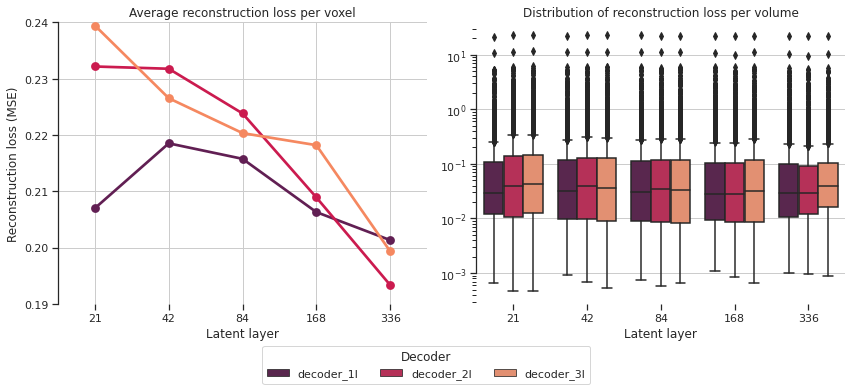

In [18]:
df_loss_filtered = df_loss[df_loss.exclude.apply(str) == "[]"]

fig, axes = plt.subplots(1, 2, figsize=(6 * 2, 5))

plot = sns.pointplot(
    x="n_features",
    y="loss",
    hue="decoder",
    hue_order=["decoder_1l", "decoder_2l", "decoder_3l"],
    data=df[
        df.exclude.apply(str) == "[]"
    ],  # boolean index on models that do not exclude features (ie: empty list in 'exclude' row)
    palette="rocket",
    ax=axes[0],
)
plot.set(
    xlabel="Latent layer",
    ylabel="Reconstruction loss (MSE)",
    title="Average reconstruction loss per voxel",
)
axes[0].set_ylim(0.19, 0.24)
axes[0].yaxis.grid(True)
axes[0].xaxis.grid(True)
axes[0].get_legend().remove()

plot = sns.boxplot(
    x="n_features",
    y="loss_y",
    hue="decoder",
    hue_order=["decoder_1l", "decoder_2l", "decoder_3l"],
    data=df_loss_filtered,
    palette="rocket",
    orient="v",
    ax=axes[1],
)
plot.set(
    xlabel="Latent layer",
    ylabel="",
    title="Distribution of reconstruction loss per volume",
)
axes[1].set_yscale("log")
axes[1].yaxis.grid(True)
axes[1].get_legend().remove()

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    title="Decoder",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
)

sns.despine(trim=True, bottom=True)

plt.tight_layout()

image_path = Path(IMAGES_PATH, "reconstruction_loss_(MSE).pdf")
plt.savefig(image_path, bbox_inches="tight");

### Plot feature occurence count

Some features occure multiple times in a single model. Lets plot the top 20 most occuring features.

In [22]:
def get_feat_count(row):
    model_uri = row.artifact_uri + "/model"
    model = mlflow.pytorch.load_model(model_uri)
    logits = model.encoder.logits
    logits_size = logits.size()
    features = torch.argmax(logits, len(logits_size) - 1)
    
    counts = np.bincount(features)
    counts_df = pd.DataFrame(counts, columns=["count"])
    return counts_df


def get_feat_counts(data):
    counts_dfs = []
    if type(data) is pd.DataFrame:
        for _, row in data.iterrows():
            counts_df = get_feat_count(row)
            counts_dfs.append(counts_df)
    else:  # assume it is a Series
        counts_df = get_feat_count(data)
        counts_dfs.append(counts_df)
    # sum all the bin counts
    df_counts = pd.concat(counts_dfs).groupby(level=0).sum().reset_index()
    return df_counts


get_feat_count(df.iloc[0]).reset_index()

,index,count
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1
...,...,...
1339,1339,1
1340,1340,0
1341,1341,0
1342,1342,0


2021/10/28 13:47:11 WARNING mlflow.pytorch: Stored model version '1.9.1+cu102' does not match installed PyTorch version '1.9.0+cu102'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5bb6a09940>
Traceback (most recent call last):
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1268, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5bb6a09940>
Traceback (most recent call last):
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/s

lambda: 0.1
val loss: 0.059918370097875595
reg term: tensor(0., grad_fn=<SumBackward0>)


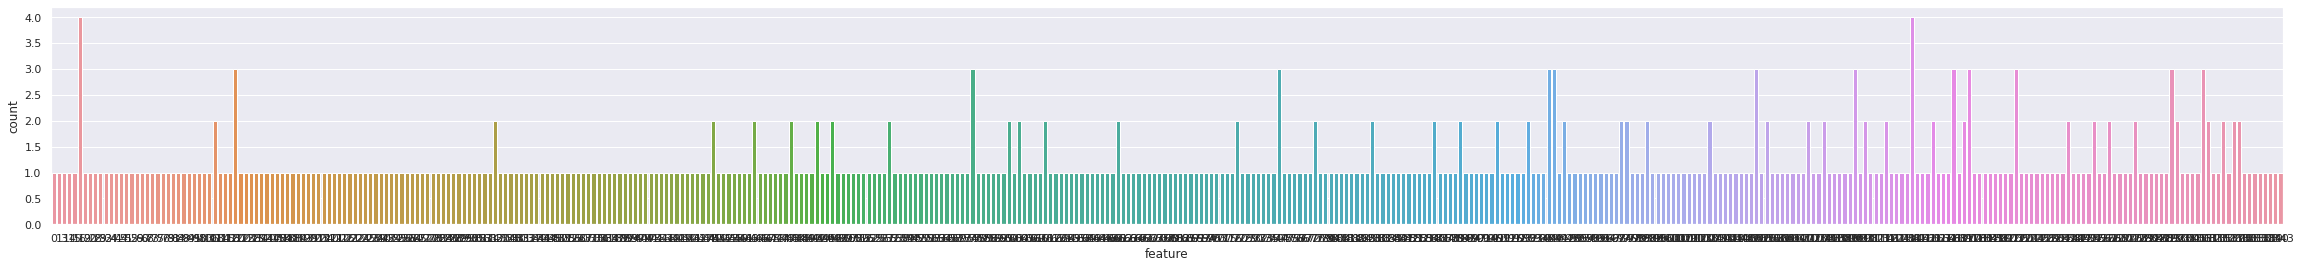

In [60]:
import torch.nn.functional as F
def feature_count(row):
    print("lambda:", row.params_lambda_reg)
    print("val loss:", row.metrics_val_loss)
    
    model_uri = row.artifact_uri + "/model"
    model = mlflow.pytorch.load_model(model_uri)
    logits = model.encoder.logits
    logits_size = logits.size()
    features = torch.argmax(logits, len(logits_size) - 1).numpy()
    
    eps = 1e-10
    threshold = 3.0
    selection = torch.clamp(F.softmax(logits, dim=0), eps, 1)
    print("reg term:", torch.sum(F.relu(torch.norm(selection, 1, dim=1) - threshold)))

    return pd.DataFrame(features, columns=["feature"])

sns.set(rc={"figure.figsize":(40, 4)})
sns.countplot(data=feature_count(df.iloc[2]), x="feature");

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5bb6a09940>
Traceback (most recent call last):
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1268, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5bb6a09940>
Traceback (most recent call last):
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1268, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProces

lambda: 0.01
val loss: 0.059603407979011536
reg term: tensor(0., grad_fn=<SumBackward0>)


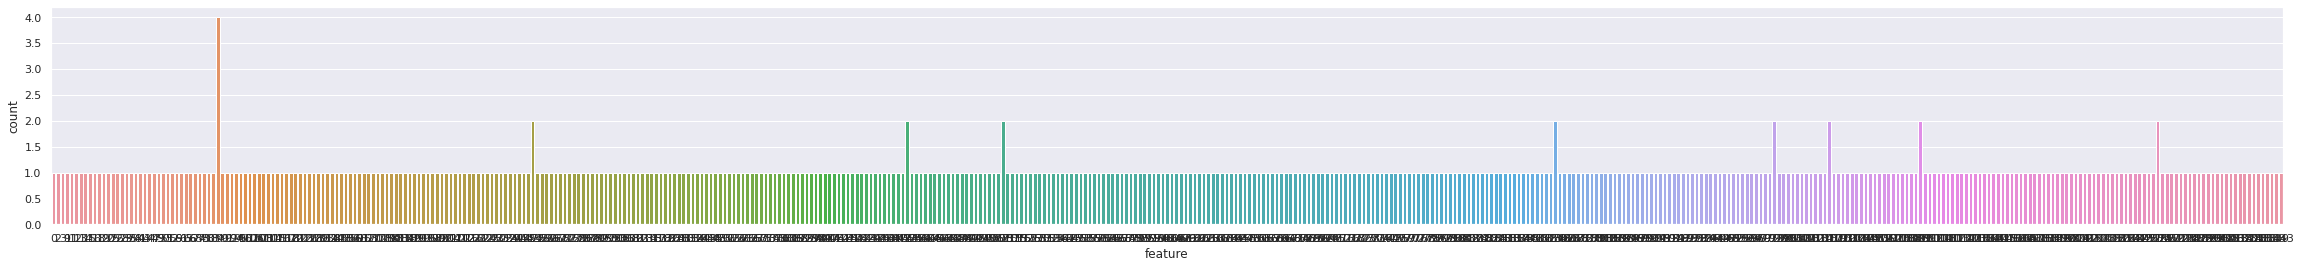

In [61]:
sns.countplot(data=feature_count(df.iloc[1]), x="feature");

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5bb6a09940>
Traceback (most recent call last):
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1268, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5bb6a09940>
Traceback (most recent call last):
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1268, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProces

lambda: 0.0
val loss: 0.05942578613758087
reg term: tensor(448.3729, grad_fn=<SumBackward0>)


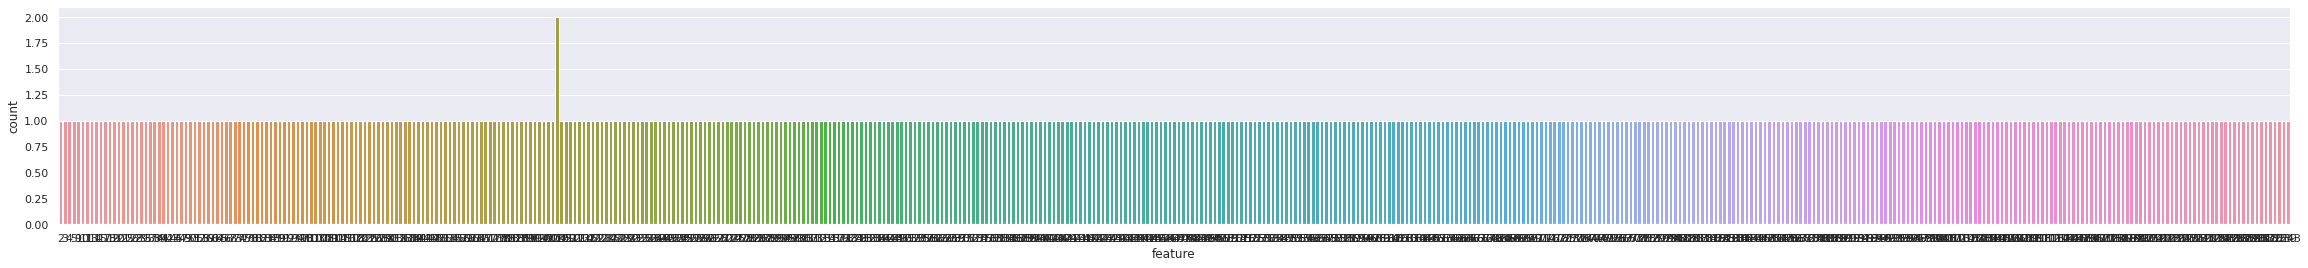

In [62]:
sns.countplot(data=feature_count(df.iloc[0]), x="feature");

In [19]:
df_counts_total

,index,count
0,0,2
1,1,1
2,2,2
3,3,3
4,4,1
...,...,...
1339,1339,3
1340,1340,1
1341,1341,0
1342,1342,0


In [27]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    """Code from https://stackoverflow.com/a/56780852/6131485"""

    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() - float(space)
                _y = p.get_y() + p.get_height() - 0.2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="right", c="white")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

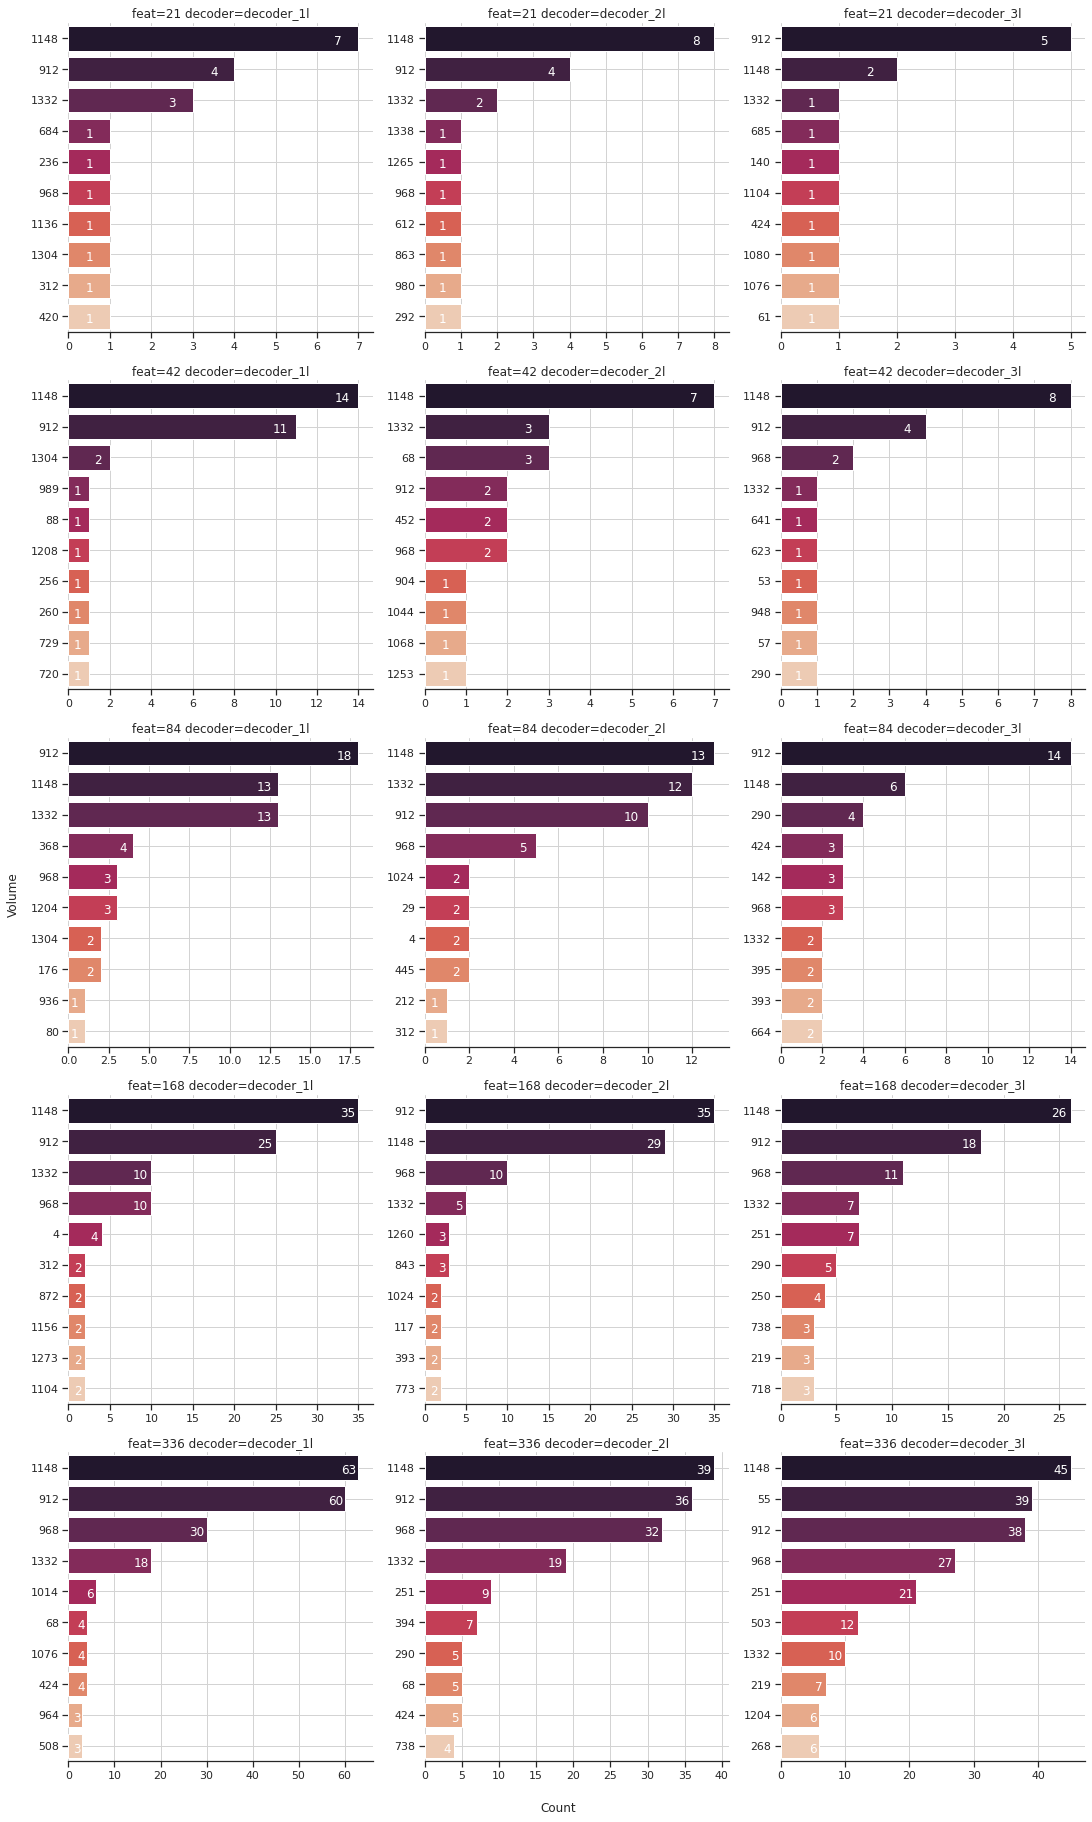

In [30]:
def plot_counts(df, top_size=10, ax=None, title=None):
    df_counts = df.sort_values(by="count", ascending=False)[:top_size]
    plot = sns.barplot(
        orient="h",
        x="count",
        y="index",
        data=df_counts,
        order=df_counts["index"].values,
        palette="rocket",
        ax=ax,
    )
    plot.set(xlabel=None, ylabel=None, title=title)
    show_values_on_bars(plot, "h")
    if ax is not None:
        ax.grid(True, which="both", ls="-", c="lightgray")


fig, axes = plt.subplots(5, 3, figsize=(5 * 3, 5 * 5))
# fig.suptitle("Volume counts for each model", x=0.5, y=1)
fig.text(0.5, -0.01, "Count", ha="center")
fig.text(-0.01, 0.5, "Volume", va="center", rotation="vertical")

for i, ax in enumerate(axes.flatten()):
    row = df.iloc[i]
    df_counts = get_feat_counts(row)
    plot_counts(
        df_counts, ax=ax, title=f"feat={row['n_features']} decoder={row['decoder']}"
    )

sns.despine(left=True)

plt.tight_layout()

image_path = Path(IMAGES_PATH, "feature_count.pdf")
plt.savefig(image_path, bbox_inches="tight");

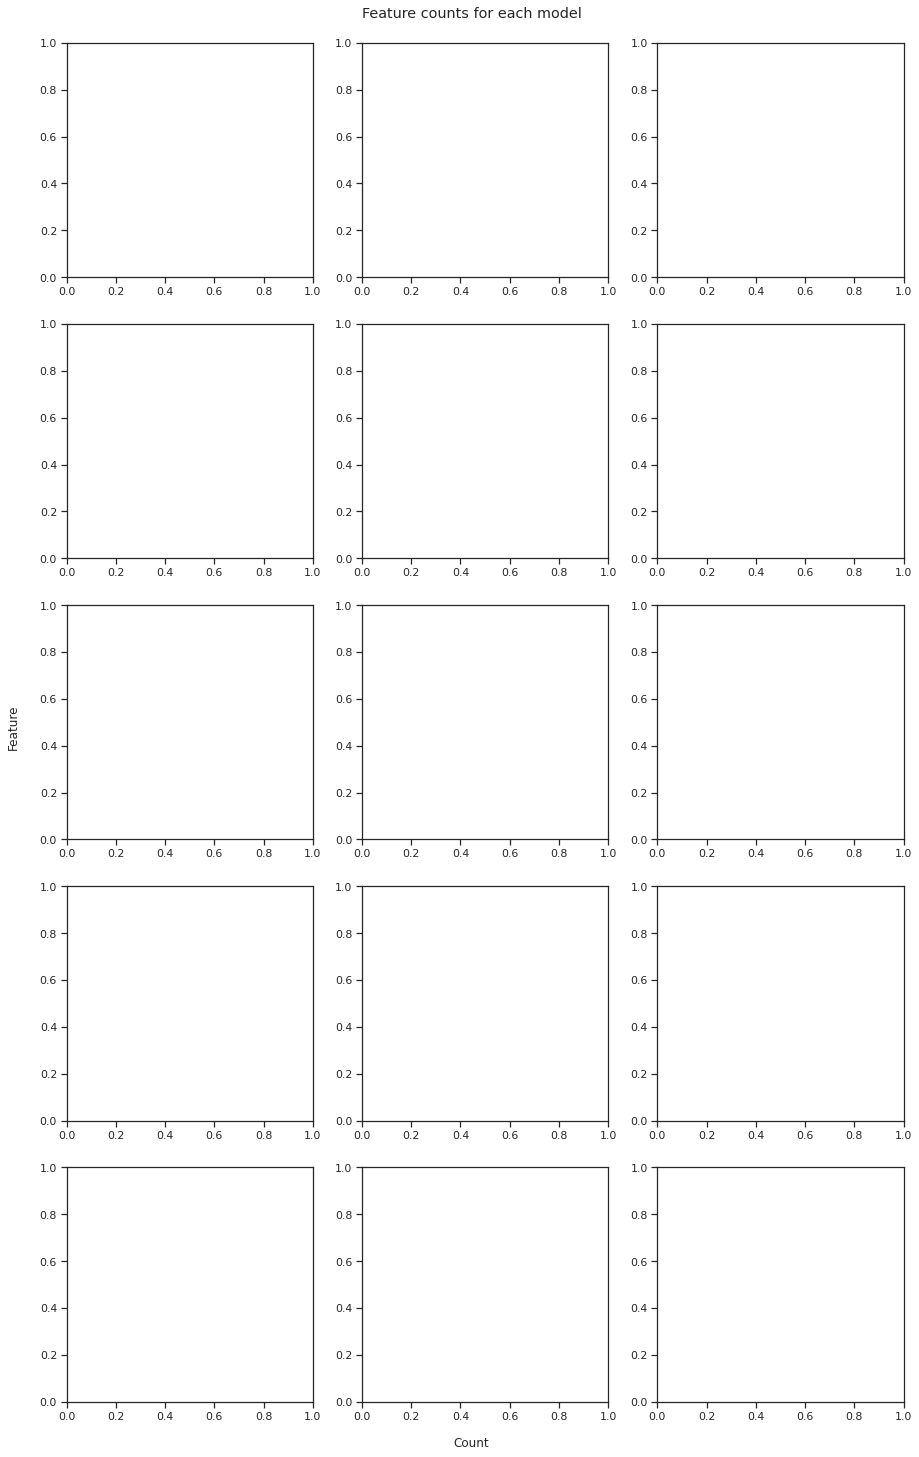

In [29]:
fig, axes = plt.subplots(5, 3, figsize=(5 * 3, 5 * 5))
fig.suptitle("Feature counts for each model", x=0.5, y=0.9)
fig.text(0.5, 0.1, "Count", ha="center")
fig.text(0.07, 0.5, "Feature", va="center", rotation="vertical")

for i, ax in enumerate(axes.flatten()):
    try:
        row = df.iloc[15 + i]
        df_counts = get_feat_counts(row)
        plot_counts(
            df_counts, ax=ax, title=f"feat={row['n_features']} decoder={row['decoder']}"
        )
    except IndexError:
        continue
image_path = Path(IMAGES_PATH, "feature_count_exclude.pdf")
plt.savefig(image_path, bbox_inches="tight");

### Interactive model plot

In [47]:
from nilearn import image, masking

In [48]:
from bokeh.io import output_notebook, show
from bokeh.layouts import column, row
from bokeh.models import (
    ColorBar,
    ColumnDataSource,
    LinearColorMapper,
    LogColorMapper,
    PreText,
    RadioButtonGroup,
    Select,
    Slider,
    Spinner,
)
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [49]:
def load_drmi(row_index):
    target, prediction = predict(
        15,
        f"{df_runs.iloc[row_index].artifact_uri}/model",
    )

    target_img = masking.unmask(
        np.transpose(target.numpy()),
        "/media/maarten/disk1/MUDI/cdmri0015/brain_mask.nii.gz",
    )
    prediction_img = masking.unmask(
        np.transpose(prediction.numpy()),
        "/media/maarten/disk1/MUDI/cdmri0015/brain_mask.nii.gz",
    )

    target_img = image.get_data(target_img)
    prediction_img = image.get_data(prediction_img)

    return target_img, prediction_img

In [90]:
def bkapp(doc):
    target_img, prediction_img = load_drmi(0)
    source = ColumnDataSource(dict(target=[], prediction=[]))

    x_max = target_img.shape[0] - 1
    y_max = target_img.shape[1] - 1
    z_max = target_img.shape[2] - 1
    max_values = [x_max, y_max, z_max]

    color_map = LogColorMapper(palette="Greys256", low=0.01, high=255)

    target_fig = figure(
        title="Truth",
        tooltips=[("X", "$sx"), ("Y", "$sy"), ("Value", "@target")],
        toolbar_location="below",
        output_backend="webgl",
    )
    target_fig.image(
        image="target", source=source, x=0, y=0, dw=10, dh=10, color_mapper=color_map
    )

    prediction_fig = figure(
        title="Prediction",
        tooltips=[("X", "$sx"), ("Y", "$sy"), ("Value", "@prediction")],
        x_range=target_fig.x_range,
        y_range=target_fig.y_range,
        toolbar_location="below",
        output_backend="webgl",
    )
    prediction_fig.image(
        image="prediction",
        source=source,
        x=0,
        y=0,
        dw=10,
        dh=10,
        color_mapper=color_map,
    )
    color_bar = ColorBar(color_mapper=color_map, label_standoff=12)
    prediction_fig.add_layout(color_bar, "right")

    options = list(
        zip(
            np.arange(len(df_runs)).astype(str),
            list(df_runs.run_id),
        )
    )

    model_select = Select(
        title="Model:",
        value="0",
        options=options,
    )
    slice_slider = Slider(start=0, end=x_max, value=0, step=1, title="Slice")
    feature_slider = Spinner(low=0, high=1343, value=0, step=1, title="Feature:")
    axis_radio = RadioButtonGroup(labels=["X", "Y", "Z"], active=0)

    def model_update():
        target_img, prediction_img = load_drmi(int(model_select.value))
        update()

    def update():
        feature_value = feature_slider.value
        axis_value = axis_radio.active

        slice_slider.end = max_values[axis_value]
        if slice_slider.value > slice_slider.end:
            slice_slider.value = slice_slider.end

        slice_value = slice_slider.value
        
        color_map.high = np.max(target_img)

        if axis_value == 0:  # X
            source.data = dict(
                target=[target_img[slice_value, :, :, feature_value]],
                prediction=[prediction_img[slice_value, :, :, feature_value]],
            )
        elif axis_value == 1:  # Y
            source.data = dict(
                target=[target_img[:, slice_value, :, feature_value]],
                prediction=[prediction_img[:, slice_value, :, feature_value]],
            )
        elif axis_value == 2:  # Z
            source.data = dict(
                target=[target_img[:, :, slice_value, feature_value]],
                prediction=[prediction_img[:, :, slice_value, feature_value]],
            )

    model_select.on_change("value", lambda attr, old, new: model_update())
    slice_slider.on_change("value", lambda attr, old, new: update())
    feature_slider.on_change("value", lambda attr, old, new: update())
    axis_radio.on_change("active", lambda attr, old, new: update())

    layout = row(
        column(model_select, axis_radio, feature_slider, slice_slider),
        target_fig,
        prediction_fig,
    )
    doc.add_root(layout)

In [92]:
os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "127.0.0.1:8888"
show(bkapp)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff653dbe1f0>
Traceback (most recent call last):
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1268, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff653dbe1f0>
Traceback (most recent call last):
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/maarten/miniconda3/envs/mudi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1268, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProces

In [ ]:
show(bkapp)